<a href="https://colab.research.google.com/github/BojanFaletic/research/blob/master/TimeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [369]:
!pip install einops
!pip install wandb -qqq
import wandb

     |████████████████████████████████| 1.6 MB 4.2 MB/s 
     |████████████████████████████████| 97 kB 6.8 MB/s 
     |████████████████████████████████| 170 kB 50.4 MB/s 
     |████████████████████████████████| 133 kB 54.1 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 


In [401]:
wandb.login()

True

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
from einops import rearrange
import matplotlib.pyplot as plt

In [26]:
data = np.load('weak_data.npy')

In [27]:
s = rearrange(data, 'w d h -> (w d) h')

In [402]:
class TimeNet(nn.Module):
    def __init__(self, hr_inp=24):
        super().__init__()
        self.l = nn.LSTM(hr_inp, hr_inp, num_layers=2)
        self.fc1 = nn.Linear(hr_inp, hr_inp)
        self.fc2 = nn.Linear(hr_inp, 1)
    
    def forward(self, x):
        x, _ = self.l(x)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

In [403]:
def filter_zeros(s_flat, HR_data):
  d = [s_flat[i:i+HR_DATA] for i in range(len(s_flat[:-HR_DATA]))]
  x = []
  y = []

  for i in range(len(d)):
    if any(d[i] != 0):
      x.append(d[i])

  for i in range(1, len(x)):
    y.append(x[i][-1])

  x = x[:-1]
  x = np.array(x, dtype=np.uint8).reshape(-1, HR_DATA)
  y = np.array(y, dtype=np.uint8).reshape(-1, 1)
  
  # checks
  assert x.shape[0] == y.shape[0], "Size of elements must match"

  for i in range(0, x.shape[0]-1):
    assert x[i+1][-1] == y[i,0], "Prev data sample must be next y" 

  return x, y

In [404]:
s_flat = np.array([np.uint8(x>1) for x in s.flatten()])
HR_DATA = int((24)*1)

X,Y = filter_zeros(s_flat, HR_DATA)

In [405]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = TimeNet(HR_DATA)
net = net.to(device)

In [406]:
SPLIT_RATIO = 0.9
BATCH_SIZE = 32

x_sz = int(X.shape[0] * SPLIT_RATIO )

X_in = torch.Tensor(X[:x_sz])
Y_in = torch.Tensor(Y[:x_sz])

X_val = torch.Tensor(X[x_sz:])
Y_val = torch.Tensor(Y[x_sz:])


d_set_val = TensorDataset(X_val, Y_val)
d_set_train = TensorDataset(X_in, Y_in)


dataloader_val = DataLoader(d_set_val, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=0)

dataloader_train = DataLoader(d_set_train, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=0)

In [407]:
def random_baseline(Y):
  y = Y.detach().numpy().flatten()
  on_off = np.sum((y == 0)) / y.size
  return f"Random guess: {on_off*100:0.2f}%"
random_baseline(Y_val)

'Random guess: 65.91%'

In [408]:
def test():
    err = 0
    with torch.no_grad():
      for i,(x, y) in enumerate(dataloader_val):
          x = x.expand(1, -1, HR_DATA)
          x = x.to(device)
          p_output = net(x)
          yy = p_output.cpu().detach().numpy()
          xx = y.numpy()
          err += np.sum(np.abs(yy - xx) > 0.5)
      err = err / np.prod(Y_val.shape)
    return (1-err)*100

print(f'Eval Acc: {test(): .2f}%')

Eval Acc:  65.91%


In [409]:
# save model
torch.save(net, 'time_net.pth')
net = torch.load('time_net.pth')

In [411]:
loss = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-2, weight_decay=0, amsgrad=1)
scheduler = StepLR(optimizer, 1, gamma=0.9)

wandb.init(
      # Set entity to specify your username or team name
      # ex: entity="carey",
      # Set the project where this run will be logged
      project="timeNet", 
      # Track hyperparameters and run metadata
      config={
      "learning_rate": 1e-3,
      "architecture": "LSTM",
      "dataset": "time_series_costum",})

def train():   
    for eps in range(40):
        net.train()
        err = 0
        for i,(x,y) in enumerate(dataloader_train):
            optimizer.zero_grad()

            # prob out
            x = x.expand(1, -1, HR_DATA).to(device)
            p_output = net(x)

            #p_output = p_output.squeeze(0)
            y = y.expand(1, -1, 1).to(device)
            
            #print(p_output.shape, y.shape)
            #print(p_output, y)

            error = loss(p_output, y)
            error.backward()
            optimizer.step()
            err += error.item()

            # logging loss
            if i % 100 == 99:
              wandb.log({"loss":err, "acc": test()})
              err = 0

        #print(f'Eps: {eps}, Train Loss: {err : .2f}')
        print(f"Epoch: {eps}, Optimizer lr: {scheduler.get_last_lr()[0]:.2e}")
        #test()
        scheduler.step()
    wandb.finish()
train()

Epoch: 0, Optimizer lr: 1.00e-02
Epoch: 1, Optimizer lr: 9.00e-03
Epoch: 2, Optimizer lr: 8.10e-03
Epoch: 3, Optimizer lr: 7.29e-03
Epoch: 4, Optimizer lr: 6.56e-03
Epoch: 5, Optimizer lr: 5.90e-03
Epoch: 6, Optimizer lr: 5.31e-03
Epoch: 7, Optimizer lr: 4.78e-03
Epoch: 8, Optimizer lr: 4.30e-03
Epoch: 9, Optimizer lr: 3.87e-03
Epoch: 10, Optimizer lr: 3.49e-03
Epoch: 11, Optimizer lr: 3.14e-03
Epoch: 12, Optimizer lr: 2.82e-03
Epoch: 13, Optimizer lr: 2.54e-03
Epoch: 14, Optimizer lr: 2.29e-03
Epoch: 15, Optimizer lr: 2.06e-03
Epoch: 16, Optimizer lr: 1.85e-03
Epoch: 17, Optimizer lr: 1.67e-03
Epoch: 18, Optimizer lr: 1.50e-03
Epoch: 19, Optimizer lr: 1.35e-03
Epoch: 20, Optimizer lr: 1.22e-03
Epoch: 21, Optimizer lr: 1.09e-03
Epoch: 22, Optimizer lr: 9.85e-04
Epoch: 23, Optimizer lr: 8.86e-04
Epoch: 24, Optimizer lr: 7.98e-04
Epoch: 25, Optimizer lr: 7.18e-04
Epoch: 26, Optimizer lr: 6.46e-04
Epoch: 27, Optimizer lr: 5.81e-04
Epoch: 28, Optimizer lr: 5.23e-04
Epoch: 29, Optimizer lr:

loss,22.68775
acc,81.92863
_runtime,69
_timestamp,1629651333
_step,119


loss,██▇▇▇▆▆▆▆▆▆▆▆▆▅▅▅▅▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁
acc,▃▃▃▃▁▁▁▁▁▃▂▃▃▃▃▃▃▃▃▃███▇▇▇▇▇▇▇▇███▇▇▇▇▇▇
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


In [377]:
X_sim = X_val.reshape(-1, HR_DATA)
Y_sim = Y_val.reshape(-1, 1)
out = np.array([np.round(net(x.expand(1,1,-1).to(device)).cpu().detach().numpy(), 0) for x in X_sim]).reshape(-1,1)

def draw_plot(offset, length):
  t = np.arange(length)+offset

  y = Y_sim[offset:offset+length].detach().numpy()
  err = np.abs(y - out[offset:offset+length])

  fig, ax = plt.subplots(figsize=(20,6), nrows=1, ncols=1)

  ax.plot(t, y, label='true')
  #ax.plot(t, out[offset:offset+length], label='predicted')
  ax.plot(t, err, label='error', color='r')
  ax.legend(loc=1);

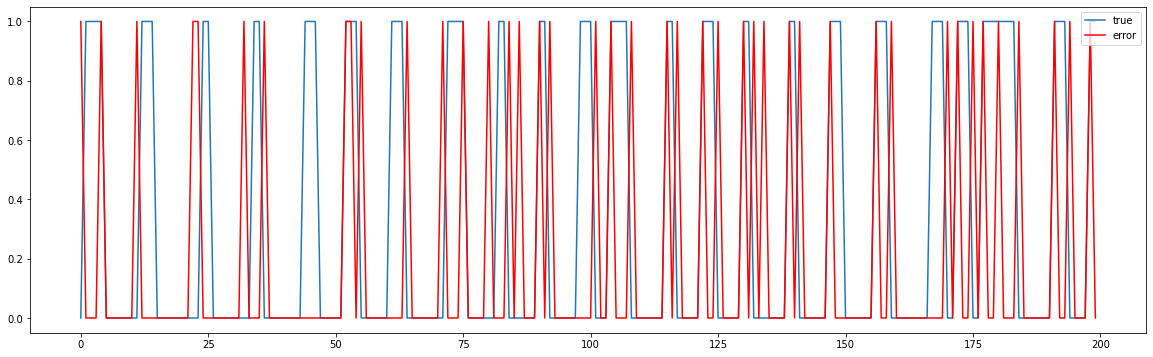

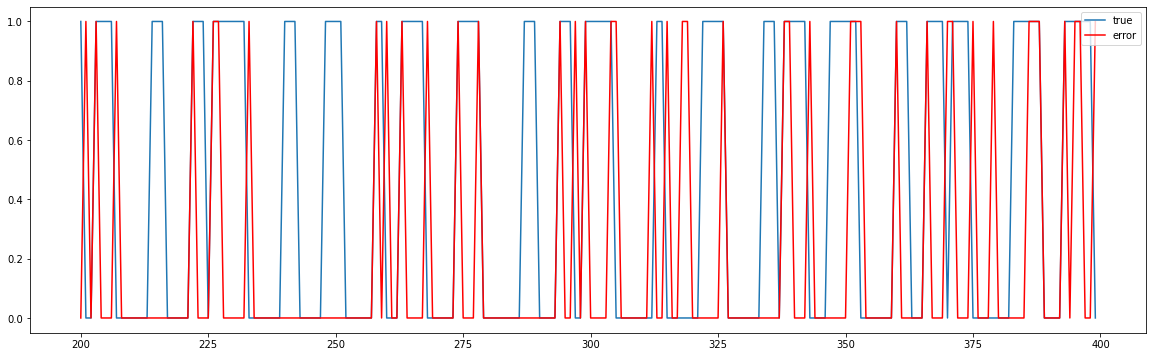

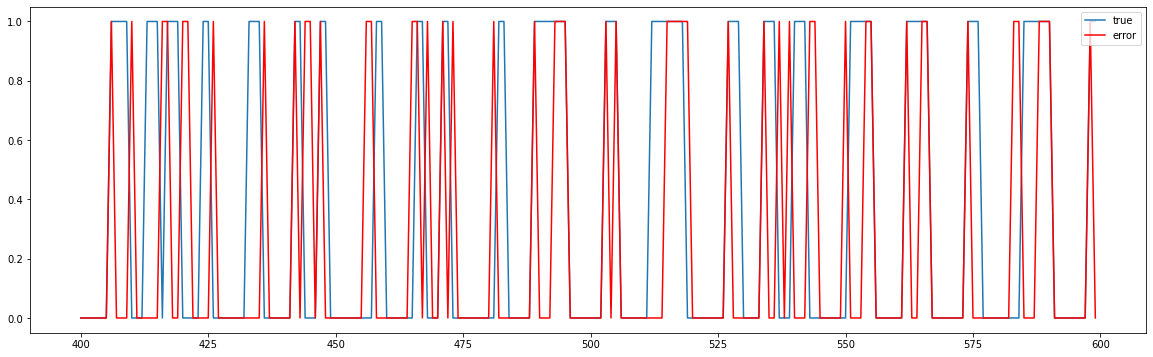

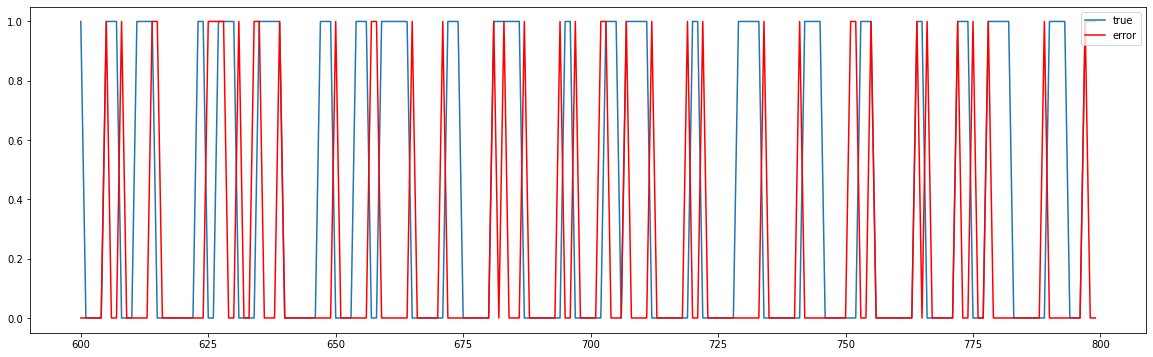

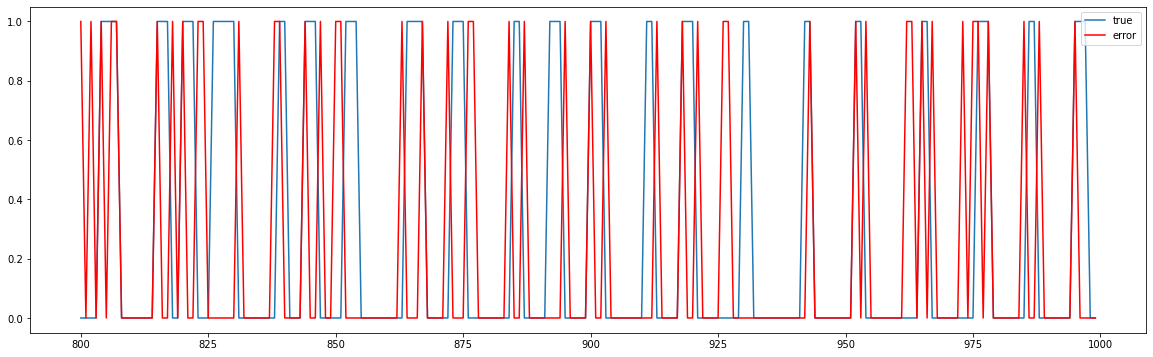

In [378]:
for i in range(5):
  draw_plot(i*200, 200)